# London - Milestone Project
This project is based on a Kaggle dataset:
https://www.kaggle.com/edenau/london-bike-sharing-system-data

You actually have to retrieve to CSV files there **yourselves**!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

In [50]:
journeys = pd.read_csv('./london-bike-sharing-system-data/journeys.csv')

## First checks on journeys

In [3]:
journeys.sample(3)

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
1372034,764.0,12733,2,8,17,14,24,25,2,8,17,14,11,78
916706,1251.0,6257,16,8,17,18,11,356,16,8,17,17,50,29
542901,480.0,7596,30,8,17,8,0,532,30,8,17,7,52,547


In [4]:
print(journeys['Start Year'].unique())
print(journeys['Start Month'].unique())

[17]
[9 8]


### Only data of 2017 august and september.

### How many unique station are there?

In [5]:
print(len(journeys['Start Station ID'].unique()))
print(len(journeys['End Station ID'].unique()))

779
779


### Null values

In [6]:
journeys.isna().sum()

Journey Duration    0
Journey ID          0
End Date            0
End Month           0
End Year            0
End Hour            0
End Minute          0
End Station ID      0
Start Date          0
Start Month         0
Start Year          0
Start Hour          0
Start Minute        0
Start Station ID    0
dtype: int64

## Convert date and create day of week column

In [7]:
start_time = []
for year, month, day, hour, minute in zip(journeys['Start Year'],journeys['Start Month'],journeys['Start Date'],journeys['Start Hour'],journeys['Start Minute']):
    time_string = '20' + str(year) + ',' + str(month) + ',' + str(day) + ',' + str(hour) + ',' + str(minute)
    timestamp = pd.Timestamp(year = 2000 + year, month = month, day = day, hour = hour, minute = minute)
    start_time.append(timestamp)
    
journeys['start_time'] = start_time

In [8]:
end_time = []
for year, month, day, hour, minute in zip(journeys['End Year'],journeys['End Month'],journeys['End Date'],journeys['End Hour'],journeys['End Minute']):
    time_string = '20' + str(year) + ',' + str(month) + ',' + str(day) + ',' + str(hour) + ',' + str(minute)
    timestamp = pd.Timestamp(year = 2000 + year, month = month, day = day, hour = hour, minute = minute)
    end_time.append(timestamp)

journeys['end_time'] = end_time

In [9]:
journeys['day_of_week'] = journeys.start_time.dt.dayofweek

In [10]:
journeys.sample(3)

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID,start_time,end_time,day_of_week
903827,2251.0,1605,16,8,17,11,59,228,16,8,17,11,21,159,2017-08-16 11:21:00,2017-08-16 11:59:00,2
1278437,1789.0,4381,13,8,17,20,40,307,13,8,17,20,10,307,2017-08-13 20:10:00,2017-08-13 20:40:00,6
400175,300.0,3011,11,9,17,8,37,39,11,9,17,8,32,702,2017-09-11 08:32:00,2017-09-11 08:37:00,0


### 1a) Plot Journey Durations
In your journey data, you have the journey duration for all trips. Play around with the plotting tools we talked about - do **journey durations depend on the time of day?**

## Overall correlation check

In [11]:
journeys.drop(columns = ['Start Year','End Year','End Date','End Month','End Year','End Hour','End Minute','End Station ID']).corr().style.background_gradient(cmap='coolwarm')

,Journey Duration,Journey ID,Start Date,Start Month,Start Hour,Start Minute,Start Station ID,day_of_week
Journey Duration,1.000000,-0.001934,0.001592,-0.016379,0.006024,-0.001061,0.009561,0.025860
Journey ID,-0.001934,1.000000,-0.002238,-0.000889,-0.004119,0.000206,-0.004579,0.000261
Start Date,0.001592,-0.002238,1.000000,-0.347641,0.013177,-0.000799,0.007320,-0.059801
Start Month,-0.016379,-0.000889,-0.347641,1.000000,-0.028264,0.000578,-0.007622,0.013441
Start Hour,0.006024,-0.004119,0.013177,-0.028264,1.000000,-0.054664,-0.029800,0.027991
Start Minute,-0.001061,0.000206,-0.000799,0.000578,-0.054664,1.000000,-0.002813,0.002671
Start Station ID,0.009561,-0.004579,0.007320,-0.007622,-0.029800,-0.002813,1.000000,0.051351
day_of_week,0.025860,0.000261,-0.059801,0.013441,0.027991,0.002671,0.051351,1.000000


### No significant correlation in data : )

### Anyway, let's look at it in a scatter plot.

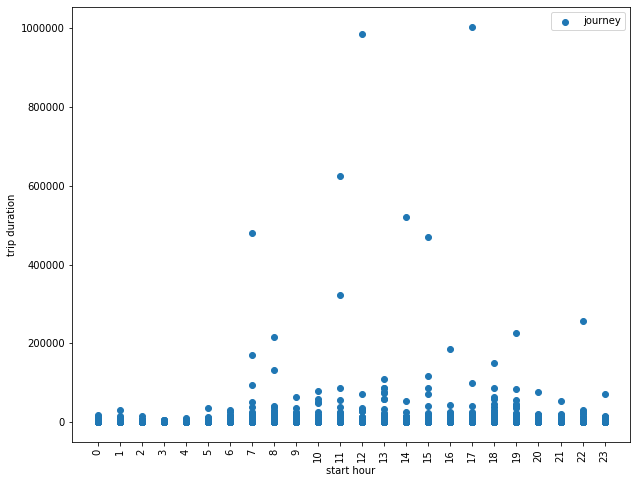

In [12]:
plt.figure(figsize = (10, 8))
# Plotting 'only' 50000 trips to speed up the process
plt.scatter(journeys['Start Hour'].sample(50000),journeys['Journey Duration'].sample(50000), label="journey")
plt.xticks(np.arange(24),np.arange(24),rotation=90)
plt.xlabel('start hour')
plt.ylabel('trip duration')

plt.legend()
plt.show()

### Surprise: Little to no correlation.
### Check on outliers.

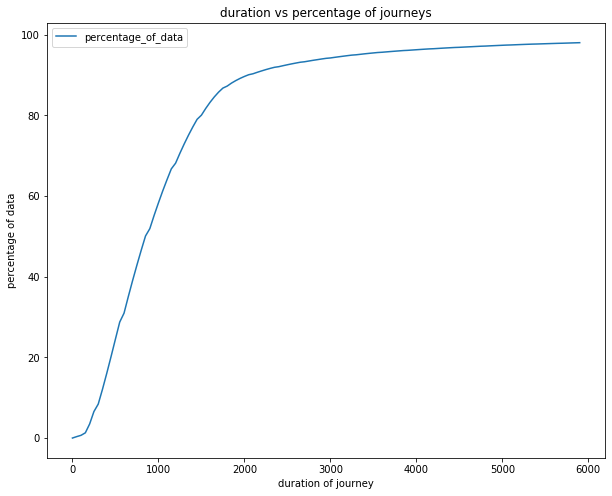

In [51]:
percent_of_original_data = []
for i in range(0,50000,50):
    percent = len(journeys[journeys['Journey Duration'] < i])/len(journeys)*100
    percent_of_original_data.append(percent)
    if percent > 98:
        break

plt.figure(figsize=(10,8))
plt.plot(np.arange(len(percent_of_original_data))*50, percent_of_original_data, label='percentage_of_data')
plt.xlabel('duration of journey')
plt.ylabel('percentage of data')
plt.title('duration vs percentage of journeys')
plt.legend()
plt.savefig('trip_duration_vs_percentage_of_trips.pdf',format='pdf')
plt.show()

In [14]:
print('Percentage of original data if drop trips > 3000 seconds: ' + str((len(journeys[journeys['Journey Duration'] < 3000]))/(len(journeys))*100))

Percentage of original data if drop trips > 3000 seconds: 94.22002483724862


### Drop all journeys over 3000 seconds

In [15]:
journeys = journeys[journeys['Journey Duration'] < 3000]

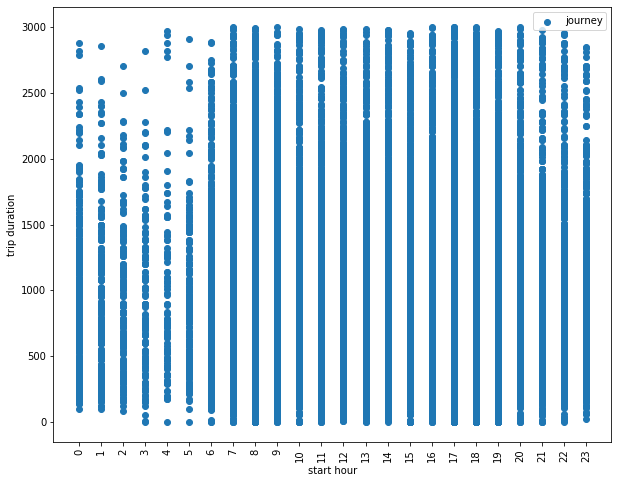

In [16]:
plt.figure(figsize = (10, 8))
plt.scatter(journeys['Start Hour'].sample(50000),journeys['Journey Duration'].sample(50000), label="journey")
plt.xticks(np.arange(24),np.arange(24),rotation=90)
plt.xlabel('start hour')
plt.ylabel('trip duration')

plt.legend()
plt.show()

### No significant correlation again

### 1b) Predict Journey Durations
You have lot's of information for the trip. Use just the data that is known at the beginning of the trip (i.e., start time and start station) to predict the journy duration. Use any regression model your a comfortable with.

In [17]:
from sklearn.linear_model import LinearRegression #Linear Regression Model
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error #Metrics to evaluate the Prediction
from sklearn.model_selection import train_test_split #split data into training, holdout and test set
from sklearn.preprocessing import PolynomialFeatures #Do a Polynomial Regression

In [18]:
X = np.array([journeys['day_of_week'], journeys['Start Hour'], journeys['Start Station ID']])
X = X.T
Y = np.array(journeys['Journey Duration'])

In [19]:
# split twices to get the three sets
X_train, X_holdout_test, Y_train, Y_holdout_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)
X_holdout, X_test, Y_holdout, Y_test = train_test_split(X_holdout_test, Y_holdout_test, train_size=0.4, test_size=0.6)

In [20]:
# -- A function to train a polynomial model with the given degree d and safe the R^2 error and the mean squared error
# -- of the training set and the holdout set

def polyRegression(d, r2Train, r2Hold, mseTrain, mseHold):
    poly_reg = PolynomialFeatures (degree = d)
    x_poly = poly_reg.fit_transform(X_train.reshape(-1,3))

    model = LinearRegression(normalize = True)
    model.fit(x_poly, Y_train)
    
    #store r2 and mse for training set
    Y_pred_train = model.predict(poly_reg.fit_transform(X_train.reshape(-1,3)))
    r2Train.append(model.score(x_poly, Y_train))
    mseTrain.append(mean_squared_error(Y_train, Y_pred_train))      

    #store r2 and mse for holdout set
    Y_pred_test = model.predict(poly_reg.fit_transform(X_holdout.reshape(-1,3)))
    r2Hold.append(r2_score(Y_holdout, Y_pred_test))
    mseHold.append(mean_squared_error(Y_holdout, Y_pred_test))
    
    return model

In [21]:
# -- Call the function above for the degrees 1-18 and save the errors
r2Train = []
r2Hold = []
mseTrain = []
mseHold = []

maxD = 10

for i in range(1,maxD):
    polyRegression(i, r2Train, r2Hold, mseTrain, mseHold)

In [22]:
mseTrain_normalized = mseTrain / np.linalg.norm(mseTrain)
mseHold_normalized = mseHold / np.linalg.norm(mseHold)

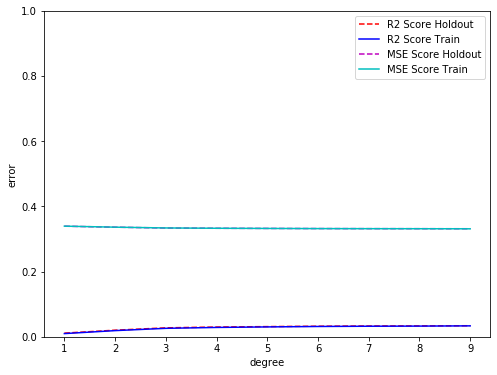

In [23]:
# -- Visualizing the loss for every degree to find the best one
plt.figure(figsize = (8,6))

plt.plot(np.arange(1, maxD), np.array(r2Hold), "r--",label="R2 Score Holdout", )
plt.plot(np.arange(1, maxD), np.array(r2Train), "b",label="R2 Score Train ")
plt.plot(np.arange(1, maxD), np.array(mseHold_normalized), "m--",label="MSE Score Holdout")
plt.plot(np.arange(1, maxD), np.array(mseTrain_normalized), "c",label="MSE Score Train ")

plt.xlabel("degree")
plt.ylabel("error")
plt.ylim((0,1))
plt.legend()
plt.show()

### 2a) Stations
In the "Folium" Notebook, I showed you how to create a colored map with some data. Try to create a similar map using the number of stations in the different boroughs of London (provided as GeoJson in this folder)

In [24]:
stations = pd.read_csv('./london-bike-sharing-system-data/stations.csv')
stations.head(2)

,Station ID,Capacity,Latitude,Longitude,Station Name
0,1,19,51.529163,-0.109970,"River Street , Clerkenwell"
1,2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"


In [25]:
m2 = folium.Map(location=[51.509865,-0.118092], zoom_start=10)

folium.Choropleth(geo_data=F"london-bike-sharing-system-data/boroughs.geojson").add_to(m2)

m2

Finding out suburb from coordinates:
https://towardsdatascience.com/reverse-geocoding-in-python-a915acf29eb6

# Plot stations on London map with the number of corresponding trips

In [26]:
start_stations = journeys.merge(stations, left_on='Start Station ID', right_on='Station ID')[['Latitude', 'Longitude']]
start_stations['count'] = 1

# Count total amount of rentals of each station
start_stations = start_stations.groupby(['Latitude','Longitude']).agg({'count':'sum'})

stations = stations.merge(start_stations, left_on=['Latitude','Longitude'], right_on=['Latitude','Longitude'],how='left')
stations.sort_values(by=['count'], ascending=False, inplace=True)
stations.reset_index(inplace = True)
stations.drop(columns = ['index'], inplace = True)
stations

,Station ID,Capacity,Latitude,Longitude,Station Name,count
0,14,48,51.529943,-0.123616,"Belgrove Street , King's Cross",12859.0
1,191,28,51.503117,-0.153520,"Hyde Park Corner, Hyde Park",10593.0
2,154,35,51.503791,-0.112824,"Waterloo Station 3, Waterloo",10496.0
3,303,28,51.502953,-0.158456,"Albert Gate, Hyde Park",7849.0
4,307,24,51.509908,-0.187842,"Black Lion Gate, Kensington Gardens",7543.0
...,...,...,...,...,...,...
768,519,33,51.518811,-0.011662,"Teviot Street, Poplar",195.0
769,363,24,51.529121,-0.171185,"Lord's, St. John's Wood",170.0
770,474,39,51.498125,-0.011457,"Castalia Square, Cubitt Town",166.0
771,775,33,51.496664,-0.223868,"Little Brook Green, Brook Green",NaN


### Only 773 stations - 6 missing?

In [27]:
stations.loc[stations['count'].isna(),'count'] = 0
stations['count'].isna().sum()

0

In [28]:
len(stations)

773

## Plot number of bookings from first 80 top stations

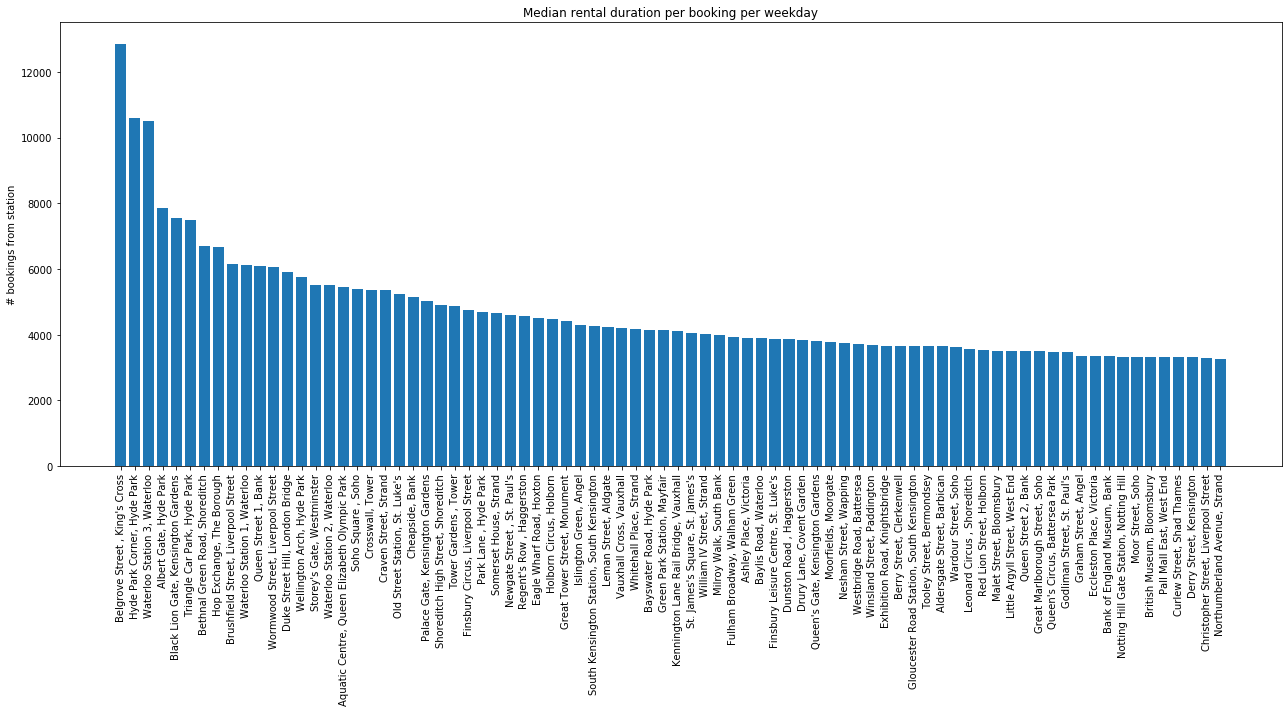

In [29]:
num_of_stations = 80

plt.figure(figsize = (18,10))
labels = stations['Station Name'][:num_of_stations]
plt.bar(height=stations['count'][:num_of_stations], label=labels, x = np.arange(num_of_stations), tick_label= labels, width=0.8)
plt.xticks(rotation=90)
plt.title('Median rental duration per booking per weekday')
plt.ylabel('# bookings from station')
plt.tight_layout()
plt.savefig('bookings_top_80.pdf',format='pdf')
plt.show()

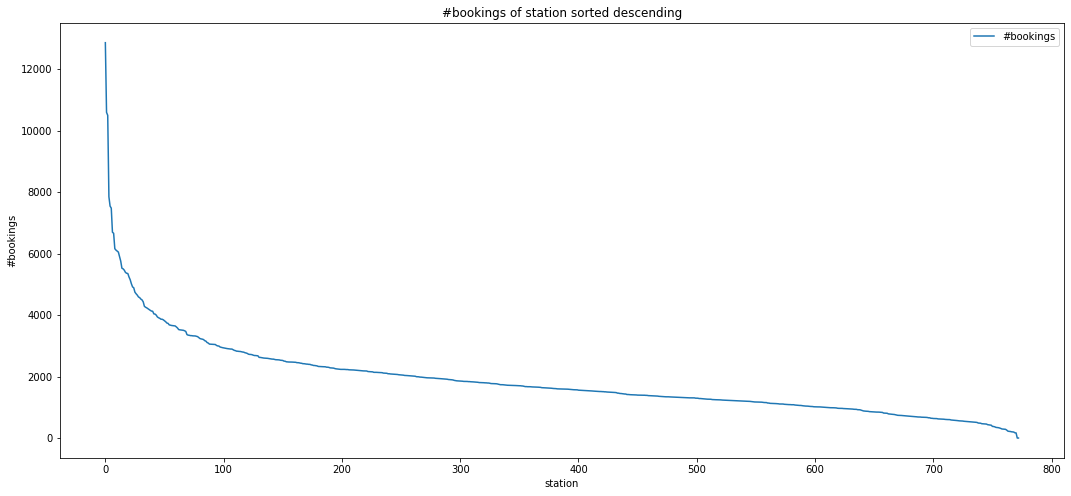

In [30]:
plt.figure(figsize=(18,8))
plt.plot(np.arange(len(stations)), stations['count'], label='#bookings')
plt.xlabel('station')
plt.ylabel('#bookings')
plt.title('#bookings of station sorted descending')
plt.legend()
plt.savefig('#bookings_of_stations.pdf',format='pdf')
plt.show()

In [31]:
m = folium.Map(location=[51.509865,-0.118092], zoom_start=12)

for index, row in stations.iterrows():
    
    station_rank = str(row.name + 1)
    station_rentals = str(round(row['count']))
    
    if isinstance((row['Station Name']), str):
        station_name = str(row['Station Name'])
    
    if not isinstance((row['Station Name']), str):
        station_name = 'Name not available'
    
    color = 'royalblue'
    
    if int(station_rank) < 81:
        color='indianred'
        
    station_info = "{}\nRank: {}\nNumber of rental from this station: {}\n".format(station_name + ' |',station_rank+ ' |',station_rentals)
    folium.Circle(
        location=[row['Latitude'],row['Longitude']],
        popup=folium.Popup(station_info, max_width = 450),
        radius=row['count']/stations['count'].max()*200,
        color=color,
        fill=True,
        fill_color=color
        
    ).add_to(m)
                  
m

In [32]:
m.save('london_bike_sharing.html')

### 2b) Coordinates
You know the stations' coordinates. Try to add two new columns to the journey DataFrame - Start Coordinate and End Coordinate

In [33]:
journeys = journeys.merge(stations, left_on='Start Station ID',right_on='Station ID', how='left')
journeys.drop(columns = ['Station ID','Capacity','count'], inplace = True)
journeys.rename(columns = {'Latitude':'start_lat', 'Longitude':'start_long','Station Name':'start_station'}, inplace = True)

In [34]:
journeys = journeys.merge(stations, left_on='End Station ID',right_on='Station ID', how='left')
journeys.drop(columns = ['Station ID','Capacity','count'], inplace = True)
journeys.rename(columns = {'Latitude':'end_lat', 'Longitude':'end_long','Station Name':'end_station'}, inplace = True)
journeys.head(2)

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,...,Start Station ID,start_time,end_time,day_of_week,start_lat,start_long,start_station,end_lat,end_long,end_station
0,2040.0,953,19,9,17,18,0,478,19,9,...,251,2017-09-19 17:26:00,2017-09-19 18:00:00,1,51.518908,-0.079249,"Brushfield Street, Liverpool Street",51.521889,-0.046670,"Stepney Green Station, Stepney"
1,1800.0,12581,19,9,17,15,21,122,19,9,...,550,2017-09-19 14:51:00,2017-09-19 15:21:00,1,51.521564,-0.039264,"Harford Street, Mile End",51.521113,-0.078869,"Norton Folgate, Liverpool Street"


### 2c) Predict direction
Knowing the coordinate you can calculate it's distance to the city center. Create two more columns in your journey DataFrame, Start Distance and End Distance. Based on these, create another column - direction - that indicates whether the journey is inbound (i.e., towards the city center), or outbound.
Use this column as target for a binary classification. As features, use only start time and start distance!

In [35]:
import math

# Function to calculate distance from a coordinate to london center
def dist_to_center(lat, long):
    dlat = 111.3 * (lat - 51.509865)
    dlong = 71.5 * (long + 0.118092)
    return math.sqrt(dlat * dlat + dlong * dlong)

### Calculating distances to london center for start and end stations and inbound for all trips

In [36]:
start_dist = []
end_dist = []
inbound = []

for index, row in journeys.iterrows():
    sd = dist_to_center(row.start_lat, row.start_long)
    ed = dist_to_center(row.end_lat, row.end_long)
    start_dist.append(sd)
    end_dist.append(ed)
    
    if sd < ed:
          inbound.append(0)
    else:
          inbound.append(1)

In [37]:
journeys['start_dist'] = start_dist
journeys['end_dist'] =  end_dist
journeys['inbound'] =  inbound
journeys.head(2)

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,...,day_of_week,start_lat,start_long,start_station,end_lat,end_long,end_station,start_dist,end_dist,inbound
0,2040.0,953,19,9,17,18,0,478,19,9,...,1,51.518908,-0.079249,"Brushfield Street, Liverpool Street",51.521889,-0.046670,"Stepney Green Station, Stepney",2.954026,5.279117,0
1,1800.0,12581,19,9,17,15,21,122,19,9,...,1,51.521564,-0.039264,"Harford Street, Mile End",51.521113,-0.078869,"Norton Folgate, Liverpool Street",5.784655,3.071184,1


In [38]:
journeys.drop(columns = ['Start Year','End Year','Journey ID','End Date','End Month','End Year','End Hour','End Minute','End Station ID']).corr().style.background_gradient(cmap='coolwarm')

,Journey Duration,Start Date,Start Month,Start Hour,Start Minute,Start Station ID,day_of_week,start_lat,start_long,end_lat,end_long,start_dist,end_dist,inbound
Journey Duration,1.000000,0.021769,-0.035908,0.038119,-0.009406,0.037093,0.087569,-0.009923,-0.038873,-0.006281,-0.039362,0.031515,0.020398,0.024005
Start Date,0.021769,1.000000,-0.344352,0.013191,-0.000816,0.006339,-0.057369,-0.001225,-0.003018,-0.002181,-0.002941,0.006851,0.007375,0.001848
Start Month,-0.035908,-0.344352,1.000000,-0.025429,0.001029,-0.007252,0.013227,-0.006228,-0.007474,-0.006421,-0.007426,-0.003984,-0.004568,-0.005690
Start Hour,0.038119,0.013191,-0.025429,1.000000,-0.055070,-0.031505,0.029297,0.021129,-0.010113,-0.033283,-0.022079,-0.053861,0.131744,-0.158265
Start Minute,-0.009406,-0.000816,0.001029,-0.055070,1.000000,-0.002797,0.002225,0.002233,0.000431,0.002740,-0.002239,-0.001097,-0.005011,0.004827
Start Station ID,0.037093,0.006339,-0.007252,-0.031505,-0.002797,1.000000,0.050815,-0.259663,-0.059437,-0.182572,-0.051919,0.501711,0.325099,0.137777
day_of_week,0.087569,-0.057369,0.013227,0.029297,0.002225,0.050815,1.000000,-0.011718,-0.008496,-0.009508,-0.009691,0.072933,0.072288,0.010150
start_lat,-0.009923,-0.001225,-0.006228,0.021129,0.002233,-0.259663,-0.011718,1.000000,0.494706,0.688617,0.449547,-0.240024,-0.198471,-0.006225
start_long,-0.038873,-0.003018,-0.007474,-0.010113,0.000431,-0.059437,-0.008496,0.494706,1.000000,0.452625,0.824154,-0.184681,-0.162365,-0.010778
end_lat,-0.006281,-0.002181,-0.006421,-0.033283,0.002740,-0.182572,-0.009508,0.688617,0.452625,1.000000,0.499172,-0.193293,-0.241320,0.032602


# Predicting inbound from start hour and start distance

In [39]:
from sklearn.linear_model import LogisticRegression

In [40]:
log_reg_df = journeys[['Start Hour','start_dist','inbound']].dropna()

In [41]:
X = log_reg_df[['Start Hour','start_dist']]
Y = log_reg_df['inbound']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
st_scaler = StandardScaler()
st_scaler.fit(X_train)
X_train_scaled = st_scaler.transform(X_train)

In [45]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
X_test_scaled = st_scaler.transform(X_test)
y_predict = log.predict(X_test_scaled)

In [47]:
y_predict

array([0, 1, 1, ..., 0, 0, 1])

In [48]:
from sklearn.metrics import classification_report

In [49]:
print(classification_report(y_true=y_test, y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.64      0.64      0.64    202572
           1       0.69      0.68      0.69    230178

    accuracy                           0.67    432750
   macro avg       0.66      0.66      0.66    432750
weighted avg       0.67      0.67      0.67    432750



### Extra - Revisit 1b)
Using not only the start time (and Station ID), but also the start distance, does your regression for journey durations improve?

### Extra - Plotting
We have been talking quite a bit about beatiful visualizations. Try to be creative and create some! 